<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [20]</a>'.</span>

### Utility

In [1]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase import Atoms 
from ase.io import Trajectory
import pandas as pd
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
import numpy as np

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode, EstimatorMethodType
from ase.io import Trajectory, write
from ase.build import bulk, surface, molecule, add_adsorbate, fcc111
from ase.constraints import ExpCellFilter, StrainFilter, FixAtoms, FixedPlane, FixBondLength
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.io.vasp import read_vasp, write_vasp
from ase.io import read
import pandas as pd
import ipywidgets as widgets
from IPython.display import display_png, Image as ImageWidget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import glob
from pathlib import Path
from PIL import Image, ImageDraw
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np
from scipy.spatial.distance import cdist

def visual2(structure,title,  max_size=(100, 100), rotation='15z,-90x',celloff=True):
    def calculate_stretch_factor(cell):
        """Calculate the stretch factor for visualization based on the cell dimensions."""
        x_length = cell[0][0]
        y_length = cell[1][1]

        # Avoid division by zero
        if y_length == 0:
            return 1.0

        stretch_y = y_length / x_length
        return stretch_y

    # Calculate stretch factor based on the structure's cell
    stretch_y = calculate_stretch_factor(structure.cell)
    temp=structure.copy()
    if celloff==True:
      temp.cell = None
    # Visualize the structure
    renderer = write('./temp.pov', temp, rotation=rotation)
    renderer.render()
    image_path = f'./temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    img.info['dpi'] = 2000
    display(img)

    # Move files to output directory
    destination = './output/'
    files = ['./temp.ini', './temp.pov', './temp.png']

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)
    original_image_path = os.path.join(destination, 'temp.png')
    new_image_path = os.path.join(destination, f'{title}.png')

    # Rename the image file
    os.rename(original_image_path, new_image_path)
    
#############################Calculator setting###################################
calc_mode="CRYSTAL" # including +U correction
model_version="v4.0.0"  # the latest model version
method_type=EstimatorMethodType.PFVM
estimator = Estimator(calc_mode=calc_mode, model_version=model_version, method_type=method_type)
calculator = ASECalculator(estimator)
##################################################################################

def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


the customization is not there yet.

In [2]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import units
from time import perf_counter
from copy import deepcopy
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase import units

def run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step):

    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)  # Set zero total momentum to avoid driftingW

    # run MD
    dyn = NVTBerendsen(atoms, time_step*units.fs, temperature_K = temperature, taut=taut*units.fs, loginterval=num_interval, trajectory=traj_filename)

    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        etot  = atoms.get_total_energy()
        temp_K = atoms.get_temperature()
        elapsed_time = perf_counter() - start_time
        print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {elapsed_time:.3f}")


    dyn.attach(print_dyn, interval=num_interval)
    dyn.attach(MDLogger(dyn, atoms,log_filename, header=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"    imd     Etot(eV)    T(K)    elapsed_time(sec)")
    dyn.run(num_md_steps)
    simulation_time = perf_counter() - start_time
    print(f"Total simulation time: {simulation_time:.3f} seconds")

In [ ]:
'''size_num=0
rand_num=2
file_names=['37','57','73']
traj = Trajectory(f"../../input/231206_wo_Pt_4more/1_5per{rand_num}.traj")
atoms = traj[size_num]
name = file_names[size_num]
atoms.calc = calculator
time_step    = 1    # fsec
temperature = 500+273
num_md_steps = 1E+5
num_interval = 5E+2
friction_coeff = 0.002
taut         = 1.0    # fs
traj_filename = f"../../output/231206_4more_wo_pt/1_5per_{file_names[size_num]}_{rand_num}.traj"
log_filename = f"../../output/231206_4more_wo_pt/1_5per_{file_names[size_num]}_{rand_num}.log"
run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step)'''

In [4]:
from ase.build import fcc111, molecule, add_adsorbate
ceo2 = read_vasp("../../ceo2_bulk")
ceo2.calc = calculator
mol = molecule("O2")
mol.calc = calculator
E_mol = get_opt_energy(mol)
E_bulk = get_opt_energy(ceo2)
print(E_bulk,len(ceo2))

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 00:53:29       -5.920261*       0.7392
LBFGS:    1 00:53:29       -5.920359*       0.7693
LBFGS:    2 00:53:29       -5.924292*       0.0295
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 00:53:29      -83.902074*       0.0008
-83.90207388577753 12


In [5]:
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.build import make_supercell
import numpy as np
from collections import Counter
from scipy.spatial import distance

def fix_atoms(atoms):
    temp=atoms.copy()
    ce_positions = np.array([temp.position for temp in temp if temp.symbol == 'Ce'])
    ce_median_z = np.median(ce_positions[:, 2])
    mask = temp.positions[:, 2] < ce_median_z
    c = FixAtoms(mask=mask)
    temp.set_constraint(c)
    num_constrained_atoms = np.sum(mask)
    print("how many fixed atoms:", num_constrained_atoms, "out of", temp.get_global_number_of_atoms())
    
    return temp
def print_slab_info(atoms):
    atoms.cell= [50,50,50]
    ce_positions = np.array([atom.position for atom in atoms if atom.symbol == 'Ce'])
    ce_min_z, ce_max_z = np.min(ce_positions[:, 2]), np.max(ce_positions[:, 2])
    ce_min_y, ce_max_y = np.min(ce_positions[:, 1]), np.max(ce_positions[:, 1])
    ce_min_x, ce_max_x = np.min(ce_positions[:, 0]), np.max(ce_positions[:, 0])
    size_x = round(ce_max_x-ce_min_x, 3)
    size_y = round(ce_max_y-ce_min_y, 3)
    size_z = round(ce_max_z-ce_min_z,3)
    print(f"length and width : {size_x} A x {size_y} x {size_z}  A")
    print(f"N_atoms: {len(atoms)}")
    symbols = atoms.get_chemical_symbols()
    element_counts = Counter(symbols)
    element_counts_line = ', '.join(f"{element}: {count}" for element, count in element_counts.items())
    print(f"Composition: {element_counts_line}")
    print("===============================")

def generate_slab(bulk, miller_index, supercell_dimensions,thick,fixoff=False):
    bulk_temp=bulk.copy()
    slab_gen = SlabGenerator(
        initial_structure=AseAtomsAdaptor.get_structure(bulk_temp),
        miller_index=miller_index,
        min_slab_size=thick,
        min_vacuum_size=40.0,
        lll_reduce=False,
        center_slab=True,
        primitive=True,
        max_normal_search=1,
    )
    
    slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
    print('N termination:',len(slab_atoms_list))
    slab = slab_atoms_list[0].copy()
    slab = slab * supercell_dimensions
    
    # Shift `slab` to the bottom of the cell
    min_pos_z = np.min(slab.positions, axis=0)[2]
    slab.set_positions(slab.positions - [0, 0, min_pos_z])
    temp = slab.copy()
    if fixoff==False:
        temp = fix_atoms(temp)
        
    return temp


length and width : 27.337 A x 27.337 x 27.337  A
N_atoms: 2385
Composition: O: 1720, Ce: 665


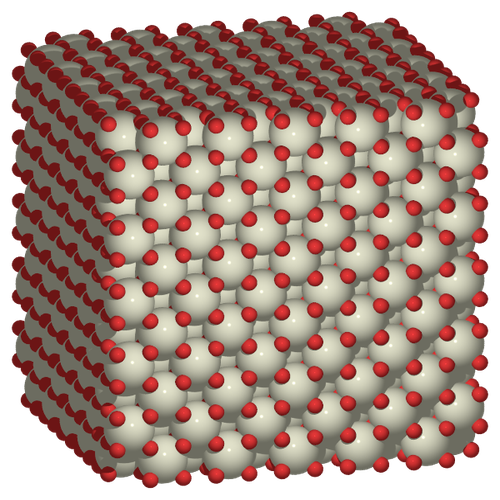

In [6]:
cube_2=read('./CeO2_03222024065326.xyz')
cube_2.pbc=True
print_slab_info(cube_2)
visual2(cube_2, f'test', (500, 500), rotation='15z,-75x', celloff=True)

In [7]:
import numpy as np
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.local_env import VoronoiNN
from pymatgen.io.ase import AseAtomsAdaptor  # Import the ASE to Pymatgen converter

def get_surface_O_sites(adslab): # input type: adslab
    pymatgen_structure = AseAtomsAdaptor.get_structure(adslab)
    a = SpacegroupAnalyzer(pymatgen_structure)
    ucell = a.get_symmetrized_structure()
    cn_dict = {}
    v = VoronoiNN()
    print(v.get_all_nn_info())
    unique_indices = [equ[0] for equ in ucell.equivalent_indices]
    for i in unique_indices:
        el = ucell[i].species_string
        if el not in cn_dict.keys():
            cn_dict[el] = []
        cn = v.get_cn(ucell, i, use_weights=True)
        cn = float("%.5f" % (round(cn, 5)))
        if cn not in cn_dict[el]:
            cn_dict[el].append(cn)
    v = VoronoiNN()
    print(v.get_all_nn_info)
    #surf_sites =  []
    #surf_sites_dict={}
    
    '''    z_median = np.median([site.frac_coords[2] for site in pymatgen_structure]) # z_median are considered as top surface sites.A cutoff value (cutoff
    for i, site in enumerate(pymatgen_structure):
        if site.frac_coords[2] > z_median:  # Consider only top surface sites
            cutoff = 1 # Surface에서 minimum coordination + cutoff_value 이하인것만 surface sites로 identify
            try:
                cn = float("%.5f" % (round(v.get_cn(pymatgen_structure, i, use_weights=True), 5)))
                if cn < min(cn_dict[site.specie.symbol]) + cutoff:
                    surf_sites.append(site)
            except RuntimeError:
                surf_sites.append(site)'''
    return 

In [8]:
import random

def get_all_surf_o_atoms(slab):
    temp = slab.copy()
    ce_indices = [atom.index for atom in temp if atom.symbol == 'Ce']
    o_indices = [atom.index for atom in temp if atom.symbol == 'O']
    o_positions = np.array([atom.position for atom in temp if atom.symbol == 'O'])
    surf_indices = []  # List to store unique indices
    for atom in temp:
        for i in [0, 1, 2]:
            if np.abs(atom.position[i] - np.min(o_positions[:, i])) < 0.2 or np.abs(atom.position[i] - np.max(o_positions[:, i])) < 0.2:
                if atom.index not in surf_indices:  # Check if index is already in the list
                    surf_indices.append(atom.index)  # Add unique index to the list
    print(len(surf_indices))
    excess_o_atoms=len(o_indices)-len(ce_indices)*2
    print("excess_o_atoms", excess_o_atoms)
    print(slab)
    selected_indices = random.sample(surf_indices, excess_o_atoms)  # Randomly select 100 indices
    del temp[selected_indices]
    #visual2(temp, f'test', (500, 500), rotation='15z,-75x', celloff=True)
    return temp
    
rand_cubes_stoi=[]
for i in range(0,10):
 rand_cubes_stoi.append(get_all_surf_o_atoms(cube_2))

720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])
720
excess_o_atoms 390
Atoms(symbols='Ce665O1720', pbc=True, cell=[50.0, 50.0, 50.0])


In [9]:
'''for strs in rand_cubes_stoi:
    visual2(strs, f'test', (100, 100), rotation='15z,-75x', celloff=True)
'''

"for strs in rand_cubes_stoi:\n    visual2(strs, f'test', (100, 100), rotation='15z,-75x', celloff=True)\n"

In [11]:
for i,strs in enumerate(rand_cubes_stoi):
    atoms = strs
    atoms.calc = calculator
    time_step    = 1   # fsec
    temperature = 400+273
    num_md_steps = 1E+3
    num_interval = 5E+1
    friction_coeff = 0.002
    taut         = 1.0    # fs
    traj_filename = f"./output/1_cube_rand_{i}.traj"
    log_filename = f"./output/1_cube_rand_{i}.log"
    run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step)

    imd     Etot(eV)    T(K)    elapsed_time(sec)
    0   -13168.108    673.00    0.134
   50   -13174.540    675.43    19.315
  100   -13180.489    676.88    38.131
  150   -13190.981    672.14    62.993
  200   -13190.987    672.79    81.605
  250   -13196.427    674.39    100.462
  300   -13193.650    674.04    124.262
  350   -13202.727    674.23    143.766
  400   -13211.963    672.37    162.602
  450   -13206.736    673.55    185.890
  500   -13209.241    669.62    204.449
  550   -13214.550    672.51    223.293
  600   -13210.998    674.13    241.591
  650   -13213.744    671.37    260.686
  700   -13213.341    675.59    278.839
  750   -13216.654    673.47    297.813
  800   -13221.974    672.81    317.687
  850   -13225.585    672.58    346.371
  900   -13221.267    675.39    365.376
  950   -13223.429    672.18    383.541
  1000   -13219.469    675.79    407.138
Total simulation time: 407.139 seconds
    imd     Etot(eV)    T(K)    elapsed_time(sec)
    0   -12845.389    673.

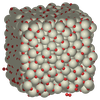

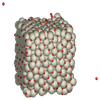

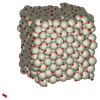

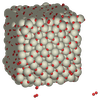

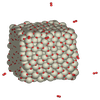

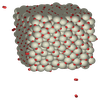

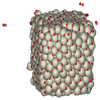

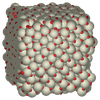

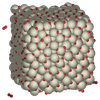

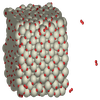

In [12]:
for strs in rand_cubes_stoi:
    visual2(strs, f'test', (100, 100), rotation='15z,-75x', celloff=True)

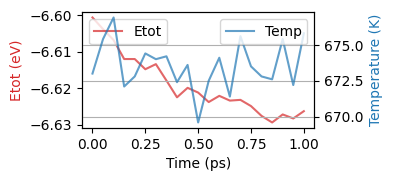

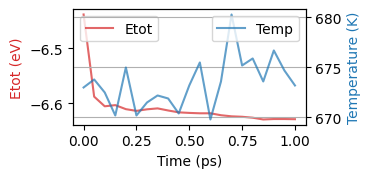

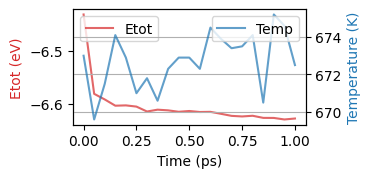

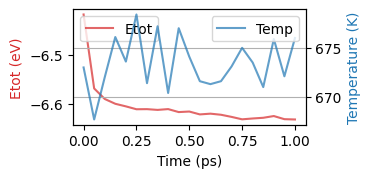

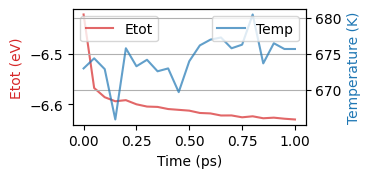

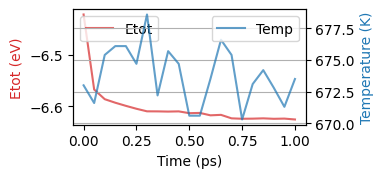

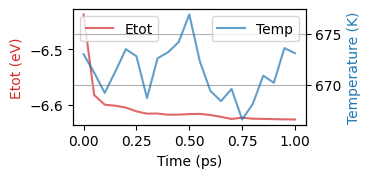

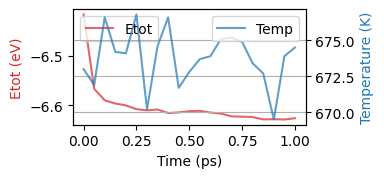

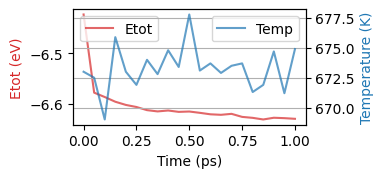

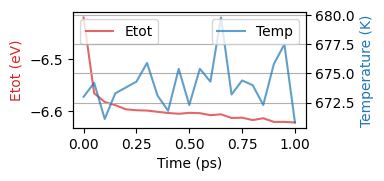

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def parse_log_file(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    run_data = []
    for line in lines:
        if "Time[ps]" not in line:
            try:
                tokens = line.split()
                time, etot, temp = float(tokens[0]), float(tokens[1]), float(tokens[4])
                run_data.append((time, etot, temp))
            except (ValueError, IndexError):
                pass
    return run_data

def plot_log_data(log_data):
    fig, ax1 = plt.subplots(figsize=(2, 1))
    time = [row[0] for row in log_data]
    etot = [row[1] for row in log_data]
    temp = [row[2] for row in log_data]
    ax1.plot(time, etot, color='tab:red', label='Etot', alpha=0.7)
    ax2 = ax1.twinx()
    ax2.plot(time, temp, color='tab:blue', label='Temp', alpha=0.7)
    ax1.set_xlabel('Time (ps)')
    ax1.set_ylabel('Etot (eV)', color='tab:red')
    ax2.set_ylabel('Temperature (K)', color='tab:blue')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()


for i, rand in enumerate(rand_cubes_stoi):
    log_filename = f"./output/1_cube_rand_{i}.log"
    log = parse_log_file(log_filename)
    plot_log_data(log)


In [14]:
energys=[]
for structure in rand_cubes_stoi:
    energys.append(get_opt_energy(structure,0.05))

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 02:08:19   -13393.737810*      10.2824
LBFGS:    1 02:08:19   -13435.634223*       4.3209
LBFGS:    2 02:08:19   -13487.609560*      21.2776
LBFGS:    3 02:08:20   -13499.744939*       4.3738
LBFGS:    4 02:08:20   -13515.131513*       4.4797
LBFGS:    5 02:08:20   -13529.943294*       4.5516
LBFGS:    6 02:08:20   -13535.856981*       4.2301
LBFGS:    7 02:08:20   -13543.079343*       1.9263
LBFGS:    8 02:08:21   -13547.681995*       4.2989
LBFGS:    9 02:08:21   -13551.676789*       5.6956
LBFGS:   10 02:08:21   -13555.552269*       1.1106
LBFGS:   11 02:08:21   -13557.874088*       0.7819
LBFGS:   12 02:08:21   -13560.634141*       1.7906
LBFGS:   13 02:08:21   -13562.477220*       1.9803
LBFGS:   14 02:08:22   -13564.268923*       1.3369
LBFGS:   15 02:08:22   -13565.727130*       0.5001
LBFGS:   16 02:08:22   -13567.011067*       1.6041
LBFGS:   17 02:08:22   -13568.2015

1995


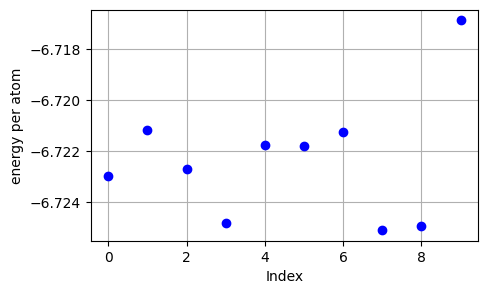

In [15]:

def plot_indices(indices):
    plt.figure(figsize=(5, 3))
    plt.plot(indices, 'bo')  # Plotting indices along the x-axis
    plt.xlabel('Index')
    plt.ylabel('energy per atom')
    plt.grid(True)
    plt.show()

print(len(atoms))
energy_list=np.array(energys)/len(atoms)
# Plot the indices
plot_indices(energy_list)


In [18]:
write('./best_2_8_cubes_stoi.vasp',rand_cubes_stoi[7])

In [17]:
write('./rand_cubes_stoi.traj',rand_cubes_stoi)

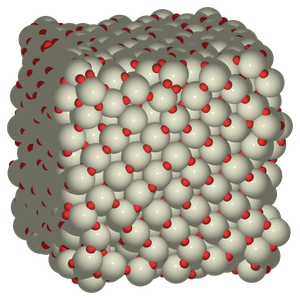

In [19]:
visual2(rand_cubes_stoi[7], f'test', (300, 300), rotation='15z,-75x', celloff=True)

In [71]:
write('./rand_3.xyz',rand_cubes_stoi[3])

In [16]:
for model in relaxed_models:
    print(model.get_total_energy())

PropertyNotImplementedError: The property "energy" is not available.